Utility Functions
- NOTE: tensors are organized as follows: [BATCH_SIZE, CHANNELS, WIDTH, HEIGHT]

In [13]:
import torch
import torch.nn.functional as func
import PIL.Image
import random
import json
import pathlib
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

from torchvision.transforms.functional_tensor import gaussian_blur
import torchvision.transforms.functional as trans
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

# * loads an image and converts to a tensor
# *     default tensor shape: [BATCH_SIZE (1), CHANNELS (4), WIDTH (_size), HEIGHT (_size)]
def load_image_as_tensor(_path, _size, _resample=PIL.Image.Resampling.BICUBIC):
    img = PIL.Image.open(_path)
    img = img.resize((_size, _size), _resample)
    img = np.float32(img) / 255.0
    img[..., :3] *= img[..., 3:]
    return torch.from_numpy(img).permute(2, 0, 1)[None, ...]

# * given a tensor of default shape, visualize the first 4 channels as a RGBA image
def show_tensor_as_image(_tensor):
    img = to_rgb(_tensor).squeeze().permute(1, 2, 0)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

# * takes the first 4 channels of a tensor of default shape and converts to a RGB image
def to_rgb(_x, _alpha='BLACK'):
    rgb, a = _x[:, :3], _x[:, 3:4]
    if _alpha == 'BLACK':
        return torch.clamp(rgb, 0.0, 1.0)
    elif _alpha == 'WHITE':
        return torch.clamp(1.-a + rgb, 0.0, 1.0)

# * creates a circle mask centered at a position of a given radius
def circle_mask(_size, _radius, _pos):
    Y, X = np.ogrid[:_size, :_size]
    dist_from_center = np.sqrt((X - _pos[0])**2 + (Y-_pos[1])**2)
    mask = dist_from_center >= _radius
    return mask

# * creates a mask for half the screen
def half_mask(_size, _type):
    mask_types = ['left', 'right', 'top', 'bottom']
    if _type == 'rand':
        _type = mask_types[np.random.randint(0, 4)]
    mat = np.zeros([_size, _size])
    if _type == 'left':
        mat[:, _size//2:] = 1.0
    elif _type == 'right':
        mat[:, :-_size//2] = 1.0
    elif _type == 'top':
        mat[_size//2:, :] = 1.0
    elif _type == 'bottom':
        mat[:-_size//2, :] = 1.0
    return mat

# * shows a batch before and after a forward pass given two (2) tensors
def show_batch(_batch_size, _before, _after, _dpi=256):
    fig = plt.figure(figsize=(_batch_size, 2), dpi=_dpi)
    axarr = fig.subplots(nrows=2, ncols=_batch_size)
    gspec = gridspec.GridSpec(2, _batch_size)
    gspec.update(wspace=0.1, hspace=0) # set the spacing between axes.
    plt.clf()
    for i in range(_batch_size):
        img_i = _before[i].unsqueeze(0)
        img_rgb = to_rgb(img_i, _alpha='BLACK').squeeze().permute(1, 2, 0)
        axarr[0, i] = plt.subplot(gspec[i])
        axarr[0, i].set_xticks([])
        axarr[0, i].set_yticks([])
        axarr[0, i].imshow(img_rgb, aspect='equal')
        axarr[0, i].set_title(str(i), fontsize=8)   
    for i in range(_batch_size):
        img_i = _after[i].unsqueeze(0)
        img_rgb = to_rgb(img_i, _alpha='BLACK').squeeze().permute(1, 2, 0)
        axarr[1, i] = plt.subplot(gspec[i+_batch_size])
        axarr[1, i].set_xticks([])
        axarr[1, i].set_yticks([])
        axarr[1, i].imshow(img_rgb, aspect='equal') 
    plt.show()

# * find GPU available
clear_output()
!nvidia-smi -L

# * sets the device
# *     defaults to 'cuda'
_DEVICE_ = 'cuda' if torch.cuda.is_available() else 'cpu'
print ('cuda available? ', torch.cuda.is_available())
print ('device: ', _DEVICE_)

GPU 0: NVIDIA GeForce GTX 1660 Ti (UUID: GPU-d77bcb98-b41a-4494-1c93-f4f7d0b55d9c)
cuda available?  True
device:  cuda


random half mask:


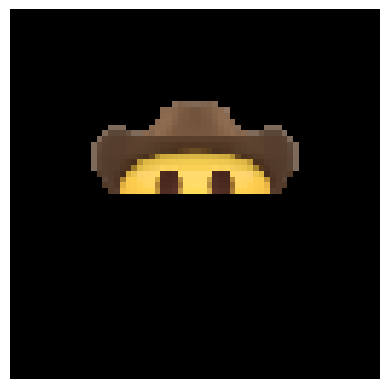

In [14]:
# experiment block

img = load_image_as_tensor('..\\_images\\'+'cowboy.png', 40)
img = func.pad(img, (12, 12, 12, 12), 'constant', 0)

mask = half_mask(64, 'rand')
img = img * torch.tensor(mask, dtype=torch.int64)
print ('random half mask:')
show_tensor_as_image(img)

Load Pre-Made Seed

seed_img.shape:  torch.Size([1, 4, 64, 64])


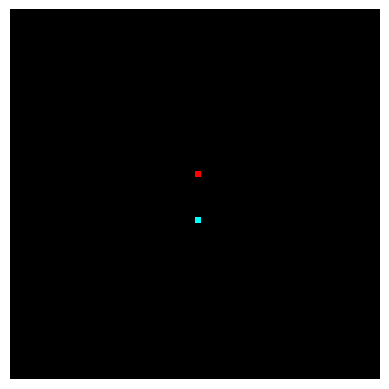

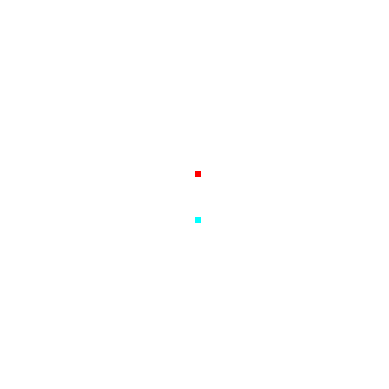

In [15]:
_SEED_FILE_ = '_2_seeds_64.png'
_SIZE_ = 64
_SEED_ANGLE_RAD_ = (0)*np.pi

seed_img = load_image_as_tensor('..\\_seeds\\'+_SEED_FILE_,  _SIZE_)
seed_img = trans.rotate(seed_img, np.rad2deg(_SEED_ANGLE_RAD_))
print ('seed_img.shape: ', seed_img.shape)
show_tensor_as_image(to_rgb(seed_img))
show_tensor_as_image(to_rgb(seed_img, 'WHITE'))

Target Image to Train Model
- NOTE: seed _SIZE_ should equal _TARGET-SIZE_ + (2 * _PAD_)

target_img.shape:  torch.Size([1, 4, 64, 64])


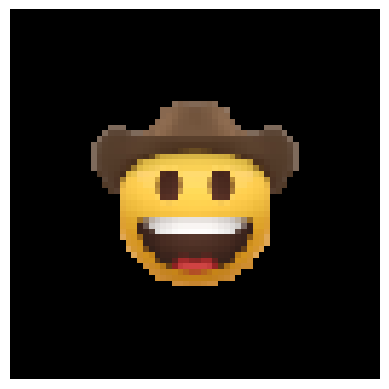

In [16]:
_TARGET_FILE_ = 'cowboy.png'
_TARGET_SIZE_ = 40
_PAD_ = 12

target_img = load_image_as_tensor('..\\_images\\'+_TARGET_FILE_, _TARGET_SIZE_)
target_img = func.pad(target_img, (_PAD_, _PAD_, _PAD_, _PAD_), 'constant', 0)
print ('target_img.shape: ', target_img.shape)
show_tensor_as_image(target_img)

Perceptions:
- LAPLACIAN: isotropic nca model
- SOBEL_MAG: isotrpic nca variant which adds upon the 'laplacian' model by making use of the magnitude of the two directional sobel filters
- ANGLE_STEER: angle-based steerable nca
- GRAD_STEER: gradient-based steerable nca

In [17]:
_SOBEL_DIV_ = 1.0
_LAP_DIV_ = 1.0

SOBEL_KERN = torch.tensor([
    [-1., 0., 1.], 
    [-2., 1., 2.], 
    [-1., 0., 1.]])
LAP_KERN = torch.tensor([
    [1.,   2., 1.], 
    [2., -12., 2.], 
    [1.,   2., 1.]])
ID_KERN = torch.tensor([
    [0., 0., 0.], 
    [0., 1., 0.], 
    [0., 0., 0.]])

# * performs a convolution per filter per channel
def per_channel_conv(_x, _filters):
    batch_size, channels, height, width = _x.shape
    # * reshape x to make per-channel convolution possible + pad 1 on each side
    y = _x.reshape(batch_size*channels, 1, height, width)
    y = func.pad(y, (1, 1, 1, 1), 'circular')
    # send to current device
    _filters = _filters.to(_DEVICE_)
    y = y.to(_DEVICE_)
    # * perform per-channel convolutions
    y = func.conv2d(y, _filters[:, None])
    y = y.reshape(batch_size, -1, height, width)
    return y

# * only uses laplacian operator for local perception
def laplacian_perception(_x):
    # * add an extra dimention to account for batch size
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :]/_LAP_DIV_)
    # * concat perception w/ self (identity)
    y = torch.cat([_x, lap_conv], 1)
    return y

# * uses laplacian operator and sobel-magnitude (G) for local perception
def sobel_mag_perception(_x):
    # * add an extra dimention to account for batch size
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :]/_LAP_DIV_)
    # * compute sobel-magnitude (G)
    sobel_conv = per_channel_conv(_x, torch.stack([SOBEL_KERN/_SOBEL_DIV_, SOBEL_KERN.T/_SOBEL_DIV_]))
    gx, gy = sobel_conv[:, ::2], sobel_conv[:, 1::2]
    # * concat perceptions w/ self (identity)
    y = torch.cat([_x, lap_conv, (gx*gx+gy*gy+1e-8).sqrt()], 1)
    return y

def angle_steerable_perception(_x):
    # * separate states and angle channels
    states, angle = _x[:, :-1], _x[:, -1:]
    # * compute lap, gx and gy
    lap_conv = per_channel_conv(states, LAP_KERN[None, :]/_LAP_DIV_)
    gx = per_channel_conv(states, SOBEL_KERN[None, :]/_SOBEL_DIV_)
    gy = per_channel_conv(states, SOBEL_KERN.T[None, :]/_SOBEL_DIV_)
    # * compute px and py 
    _cos, _sin = angle.cos(), angle.sin()
    px = (gx*_cos)+(gy*_sin)
    py = (gy*_cos)-(gx*_sin)
    # * concat and return
    y = torch.cat([states, lap_conv, px, py], 1)
    return y

def gradient_steerable_perception(_x):
    # * compute sobel x/y convolutions
    filters = torch.stack([SOBEL_KERN/_SOBEL_DIV_, SOBEL_KERN.T/_SOBEL_DIV_])
    grad = per_channel_conv(_x, filters)
    # * extract grad and dir
    grad, dir = grad[:, :-2], grad[:, -2:]
    dir = dir / dir.norm(dim=1, keepdim=True).clip(1.0)
    gx, gy = grad[:, ::2], grad[:, 1::2]
    # * rotate gx and gy using sin/cos of dir
    _cos, _sin = dir[:, :1], dir[:, 1::2]
    rot_grad = torch.cat([gx*_cos+gy*_sin, gy*_cos-gx*_sin], 1)
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :])
    # * concat and return
    y = torch.cat([_x, lap_conv, rot_grad], 1)
    return y
    
perception = {
    'LAPLACIAN': laplacian_perception,
    'SOBEL_MAG': sobel_mag_perception,
    'ANGLE_STEER': angle_steerable_perception,
    'GRAD_STEER': gradient_steerable_perception,
}

def get_alive_mask(_x):
    return func.max_pool2d(_x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1

In [18]:
# * experiments
# states = torch.randint(0, 9, [1, 3, 3, 3]).to(_DEVICE_).to(torch.float32)
# print ('states.shape:', states.shape)
# print ('states:\n', states)
# print ('--------')
# gradient_steerable_perception(states)

In [19]:
# * experiments and tests
# angle = np.random.random()*np.pi
# states = torch.randint(0, 9, [1, 1, 3, 3]).to(_DEVICE_).to(torch.float32)
# print ('angle',angle)
# print ('states.shape:',states.shape)
# print (states)

# dx = SOBEL_KERN
# dy = SOBEL_KERN.T

# # normal sobel-x convolution
# print ('normal sobel-x conv:')
# x = per_channel_conv(states, dx[None, :])
# print ('x:', x)

# # pre-rotated sobel-x convolution
# print ('pre-rot sobel-x conv:')
# _cos, _sin = np.cos(angle), np.sin(angle)
# rdx = torch.tensor(_cos*dx-_sin*dy, dtype=torch.float32)
# y = per_channel_conv(states, rdx[None, :])
# print ('y:', y)

# # post-rotated sobel-x convolution
# print ('post-rot sobel-x conv:')
# gx = per_channel_conv(states, dx[None, :])
# gy = per_channel_conv(states, dy[None, :])
# # * compute px and py
# z = (gx*_cos)-(gy*_sin)
# zy = (gx*_cos)+(gy*_sin)
# print ('z:', z)

# print ('y=z?:',torch.eq(y,z))

Isotropic Neural Cellular Automata Model

In [20]:
_CHANNELS_ = 16
_HIDDEN_ = 128
_MODEL_TYPE_ = 'ANGLE_STEER'  #['LAPLACIAN', 'SOBEL_MAG', 'ANGLE_STEER', 'GRAD_STEER']
_IS_STEERABLE_ = True if 'ANGLE_STEER' in _MODEL_TYPE_ else False
_STOCHASTIC_UPDATE_RATE_ = 0.5

class ISO_NCA(torch.nn.Module):
    def __init__(self, _channels=_CHANNELS_, _hidden=_HIDDEN_, _device=_DEVICE_, _model_type=_MODEL_TYPE_):
        super().__init__()
        self.device = _device
        _MODEL_TYPE_=_model_type

        # * determine number of perceived channels
        perception_channels = perception[_MODEL_TYPE_](torch.zeros([1, _channels, 8, 8]).to(_device)).shape[1]
        
        # * determine hidden channels (equalize the parameter count btwn model types)
        hidden_channels = 8*1024 // (perception_channels+_channels)
        hidden_channels = (_hidden+31) // 32*32
        
        # * model layers
        self.conv1 = torch.nn.Conv2d(perception_channels, hidden_channels, 1)
        self.conv2 = torch.nn.Conv2d(hidden_channels, _channels, 1, bias=False)
        with torch.no_grad():
            self.conv2.weight.data.zero_()
        
        # * send to device
        self.to(_device)
        
    def forward(self, _x):
        # * get alive mask
        alive_mask = get_alive_mask(_x).to(self.device)
        
        # * perception step
        _x = _x.to(self.device)
        p = perception[_MODEL_TYPE_](_x)
        
        # * update step
        p = self.conv2(torch.relu(self.conv1(p)))
        
        # * create stochastic update mask
        stochastic_mask = (torch.rand(_x[:, :1, :, :].shape) <= _STOCHASTIC_UPDATE_RATE_).to(self.device, torch.float32)
        
        # * perform update
        _x = _x + p * stochastic_mask
        if _IS_STEERABLE_:
            states = _x[:, :-1]*alive_mask
            angle = _x[:, -1:] % (np.pi*2.0)
            _x = torch.cat([states, angle], 1)
        else:
            _x = _x * alive_mask
        return _x

# * print model parameter count
param_n = sum(p.numel() for p in ISO_NCA().parameters())
print('ISO-NCA param count:', param_n)
print ('is steerable? '+str(_IS_STEERABLE_))

ISO-NCA param count: 9856
is steerable? True


Loss Functions

In [21]:
_LOSS_FUNC_ = 'PIXEL_WISE' #['PIXEL_WISE', 'INVARIANT']

# r = torch.linspace(0.5/_SIZE_, 1, _SIZE_//2.0)[:, None]
# a = torch.range(0, _SIZE_*np.pi)/(_SIZE_/2)
# polar_xy = torch.stack([r*a.cos(), r*a.sin()], -1)[None, :]
# polar_target = func.grid_sample(unsharpen(target_img[None, ...]), polar_xy)

# x = torch.linspace(-1, 1, _SIZE_)
# y, x = torch.meshgrid(x, x)
# xy_grid = torch.stack([x, y], -1)
# fft_target = torch.fft.rfft(polar_target).conj()
# polar_target_sqnorm = polar_target.square().sum(-1, keepdim=True)

def pixel_wise_loss_func(_x, _target, _scale=1e3, _dims=[]):
    return _scale * torch.mean(torch.square(_x[:, :4] - _target), _dims)

# def invariant_losses_func(_x):
#     img = unsharpen(_x)
#     polar_img = func.grid_sample(img, polar_xy.repeat(len(img), 1, 1, 1), mode='bicubic')
#     x = torch.fft.rfft(polar_img)
#     xy = torch.fft.irfft(x*fft_target)
#     xx = polar_img.square().sum(-1, keepdim=True)
#     yy = polar_target_sqnorm
#     diff = xx+yy-2.0*xy
#     return diff.mean([1, 2])

def invariant_loss_func(_x):
    raise NotImplementedError
    # return invariant_losses_func(_x).min(-1)[0].mean()

loss_func = {
    'PIXEL_WISE': pixel_wise_loss_func,
    'INVARIANT': invariant_loss_func
}

Create ISO-NCA Model

In [22]:
_NAME_ = 'angle_steer_cowboy_2_seeds_v5'
_POOL_SIZE_ = 256
_BATCH_SIZE_ = 8
_LOWER_LR_ = 1e-5
_UPPER_LR_ = 1e-3

# * create model / optimizer / lr-scheduler
model = ISO_NCA()
opt = torch.optim.Adam(model.parameters(), _UPPER_LR_)
lr_sched = torch.optim.lr_scheduler.CyclicLR(opt, _LOWER_LR_, _UPPER_LR_, step_size_up=2000, mode='triangular2', cycle_momentum=False)

# * create target batch
target_batch = target_img.clone().repeat(_BATCH_SIZE_, 1, 1, 1).to(_DEVICE_)

# * create seed
seed = torch.cat([seed_img, seed_img[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)

# * create training pool
with torch.no_grad():
    pool = seed.clone().repeat(_POOL_SIZE_, 1, 1, 1)
    # * randomize angles for steerable models
    if _IS_STEERABLE_:
        for i in range(_POOL_SIZE_):
            rand = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
            pool[i, -1:] = rand

Load ISO-NCA Model Checkpoint

In [23]:
load_model = False
load_from = 'checkpoints\\sobel_mag_cowboy_v2_cp14000'

def load_model_checkpoint():
    if not load_model: 
        return

    # * open params json file
    params = {}
    with open(load_from + '_params.json', 'r') as openfile:
        params = json.load(openfile)
    
    # * load in params
    _DEVICE_ = params['_DEVICE_']
    _SEED_FILE_ = params['_SEED_FILE_']
    _SIZE_ = params['_SIZE_']
    _SEED_ANGLE_RAD_ = params['_SEED_ANGLE_RAD_']
    _NAME_ = params['_NAME_']
    _MODEL_TYPE_ = params['_MODEL_TYPE_']
    _IS_STEERABLE_ = params['_IS_STEERABLE_']
    _POOL_SIZE_ = params['_POOL_SIZE_']
    _TARGET_FILE_ = params['_TARGET_FILE_']
    _TARGET_SIZE_ = params['_TARGET_SIZE_']
    _PAD_ = params['_PAD_']
    _SOBEL_DIV_ = params['_SOBEL_DIV_']
    _LAP_DIV_ = params['_LAP_DIV_']
    _BATCH_SIZE_ = params['_BATCH_SIZE_']
    _LOWER_LR_ = params['_LOWER_LR_']
    _UPPER_LR_ = params['_UPPER_LR_']
    _LOSS_FUNC_ = params['_LOSS_FUNC_']
    
    # * load state dictionary
    model.load_state_dict(torch.load(load_from + '.pt', map_location=_DEVICE_))   
    model.train()

    # * load seed
    seed_img = load_image_as_tensor('..\\_seeds\\'+_SEED_FILE_, _SIZE_)
    seed_img = trans.rotate(seed_img, np.rad2deg(_SEED_ANGLE_RAD_))
    seed = torch.cat([seed_img, seed_img[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
    
    # * create training pool
    with torch.no_grad():
        pool = seed.clone().repeat(_POOL_SIZE_, 1, 1, 1)
        # * randomize angles for steerable models
        if _IS_STEERABLE_:
            for i in range(_POOL_SIZE_):
                rand = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
                pool[i, -1:] = rand
        
    # * load target
    target_img = load_image_as_tensor('..\\_images\\'+_TARGET_FILE_, _TARGET_SIZE_)
    target_img = torch.nn.functional.pad(target_img, (_PAD_, _PAD_, _PAD_, _PAD_), 'constant', 0)
    target_batch = target_img.clone().repeat(_BATCH_SIZE_, 1, 1, 1).to(_DEVICE_)
    
    # * setup loss function etc.
    opt = torch.optim.Adam(model.parameters(), _UPPER_LR_)
    lr_sched = torch.optim.lr_scheduler.CyclicLR(opt, _LOWER_LR_, _UPPER_LR_, step_size_up=2000, mode='triangular2', cycle_momentum=False)
    
    print ('model loaded in successfully')

load_model_checkpoint()

Training Loop

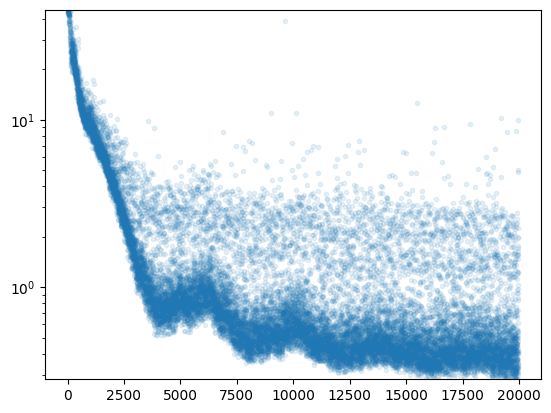

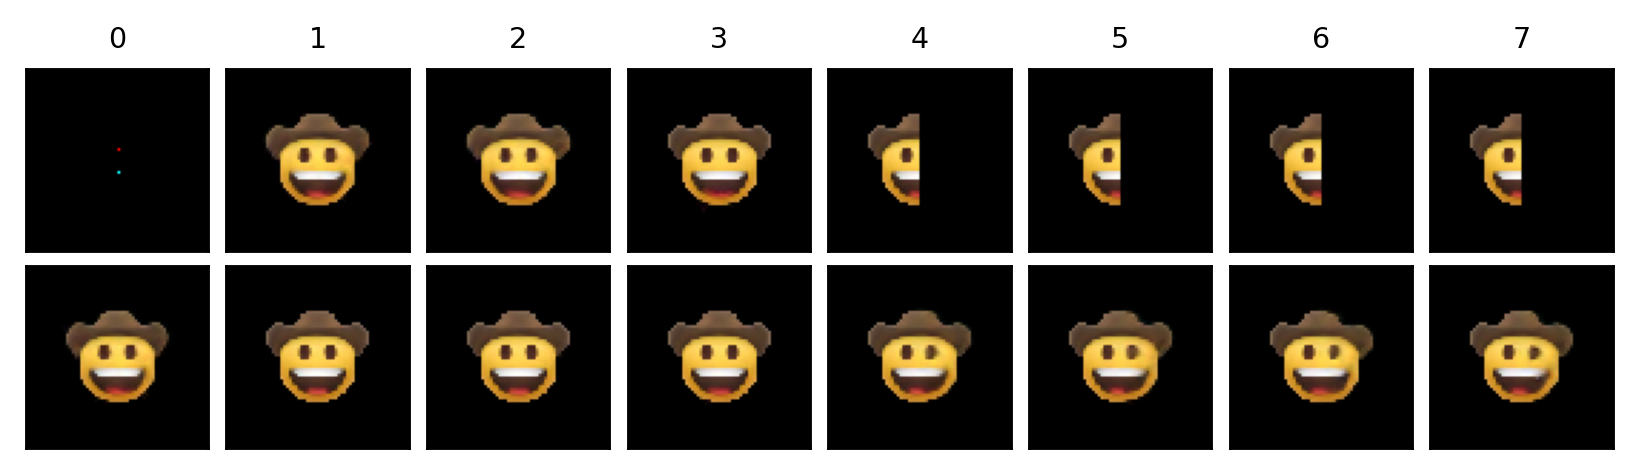

100%|█████████▉| 19981/20000 [3:11:20<00:16,  1.16it/s]

step: 19980 	loss: 1.2200000286102295 	lr: 1.058781249999995e-05

100%|██████████| 20000/20000 [3:11:30<00:00,  1.74it/s]

model + params saved!


In [24]:
_TRAIN_MODEL_ = True
_EPOCHS_ = 20_000
_NUM_DAMG_ = 4
_DAMG_RATE_ = 2
_INFO_RATE_ = 50
_SAVE_RATE_ = 1000

# * save model method
def save_model(_dir, _model, _name):
    model_path = pathlib.Path(_dir)
    model_path.mkdir(parents=True, exist_ok=True)
    torch.save(_model.state_dict(), _dir + '\\' + _name + '.pt')
    
    # * save model parameters
    dict = {
        # seed info
        '_SEED_FILE_': _SEED_FILE_,
        '_SIZE_': _SIZE_,
        '_SEED_ANGLE_RAD_':_SEED_ANGLE_RAD_,
        # target image info
        '_TARGET_FILE_': _TARGET_FILE_,
        '_TARGET_SIZE_': _TARGET_SIZE_,
        '_PAD_': _PAD_,
        # kernel dividers
        '_SOBEL_DIV_': _SOBEL_DIV_,
        '_LAP_DIV_': _LAP_DIV_,
        # model info
        '_CHANNELS_': _CHANNELS_,
        '_HIDDEN_': _HIDDEN_,
        '_MODEL_TYPE_': _MODEL_TYPE_,
        '_IS_STEERABLE_': _IS_STEERABLE_,
        '_STOCHASTIC_UPDATE_RATE_': _STOCHASTIC_UPDATE_RATE_,
        # loss/lr info
        '_LOSS_FUNC_': _LOSS_FUNC_,
        '_LOWER_LR_': _LOWER_LR_,
        '_UPPER_LR_': _UPPER_LR_,
        # training info
        '_DEVICE_': _DEVICE_,
        '_NAME_': _NAME_,
        '_EPOCHS_': _EPOCHS_,
        '_POOL_SIZE_': _POOL_SIZE_,
        '_BATCH_SIZE_': _BATCH_SIZE_,
        '_NUM_DAMG_': _NUM_DAMG_,
        # training rate info
        '_DAMG_RATE_': _DAMG_RATE_,
        '_INFO_RATE_': _INFO_RATE_,
        '_SAVE_RATE_': _SAVE_RATE_,
    }
    json_object = json.dumps(dict, indent=4)
    with open(_dir + '\\' + _name + '_params.json', 'w') as outfile:
        outfile.write(json_object)
    print ('model + params saved!')

loss_log = []
progress = 0

# * begin training 
for _ in tqdm(range(_EPOCHS_)):
    if not _TRAIN_MODEL_:
        print ('skipping training')
        break
    with torch.no_grad():
        # * sample batch from pool
        i = len(loss_log)
        batch_idxs = np.random.choice(_POOL_SIZE_, _BATCH_SIZE_, replace=False)
        x = pool[batch_idxs]
        
        # * re-order batch based on loss
        loss_ranks = torch.argsort(loss_func[_LOSS_FUNC_](x, target_batch, _dims=[-2, -3, -1]), descending=True)
        x = x[loss_ranks]
        
        # * re-add seed into batch
        x[:1] = seed

        # * randomize angles for steerable models
        if _IS_STEERABLE_:
            rand = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
            x[:1, -1:] = rand
            
        # * damage lowest loss in batch
        if i % _DAMG_RATE_ == 0:
            # * use random half mask
            if i % 10 == 0:
                mask = half_mask(_SIZE_, 'rand')
            # * use random circle mask
            else:
                radius = random.uniform(_SIZE_*0.05, _SIZE_*0.2)
                u = random.uniform(0, 1) * _SIZE_
                v = random.uniform(0, 1) * _SIZE_
                mask = circle_mask(_SIZE_, radius, [u, v])
            x[-_NUM_DAMG_:] *= torch.tensor(mask).to(_DEVICE_)
            
    # * different loss values
    overflow_loss = 0.0
    diff_loss = 0.0
    target_loss = 0.0
    
    # * save batch before
    if i % _INFO_RATE_ == 0:
        before = x.detach().cpu()
    
    # * forward pass
    num_steps = np.random.randint(64, 96)
    for _ in range(num_steps):
        prev_x = x
        x = model(x)
        diff_loss += (x - prev_x).abs().mean()
        if _IS_STEERABLE_:
            overflow_loss += (x - x.clamp(-2.0, 2.0))[:, :_CHANNELS_-1].square().sum()
        else:
            overflow_loss += (x - x.clamp(-2.0, 2.0))[:, :_CHANNELS_].square().sum()
    
    # * calculate losses
    target_loss += loss_func[_LOSS_FUNC_](x, target_batch)
    target_loss /= 2.0
    diff_loss *= 10.0
    loss = target_loss + overflow_loss + diff_loss
    
    # * backward pass
    with torch.no_grad():
        loss.backward()
        # * normalize gradients 
        for p in model.parameters():
            p.grad /= (p.grad.norm()+1e-8) 
        opt.step()
        opt.zero_grad()
        lr_sched.step()
        # * re-add batch to pool
        pool[batch_idxs] = x
        loss_log.append(loss.item())
        
        # * print out info
        if i % _INFO_RATE_ == 0:
            # * show loss plot
            clear_output(True)
            pl.plot(loss_log, '.', alpha=0.1)
            pl.yscale('log')
            pl.ylim(np.min(loss_log), loss_log[0])
            pl.show()
            
            # * show batch
            after = x.detach().cpu()
            show_batch(_BATCH_SIZE_, before, after)
            
            # * print info
            print('\rstep:', i, '\tloss:', loss.item(), '\tmin-loss:', np.min(loss_log),  '\tlr:', lr_sched.get_last_lr()[0], end='')
                
        # * save checkpoint
        if i % _SAVE_RATE_ == 0 and i != 0:
            save_model('checkpoints', model, _NAME_+'_cp'+str(i))
            
# * save final model
if _TRAIN_MODEL_:
    save_model('models', model, _NAME_)

Play Model!

In [27]:
import pygame
import datetime
import json
import os
import cv2
import imutils

_PLAY_ = True
_MODELS_DIR_ = 'models'
_PLAY_DEVICE_ = 'cpu'
_RADIUS_ = 8
_PLAY_SIZE_ = 64
_WINDOW_SCALE_ = 6
_WINDOW_BG_COLOR_ = (0, 0, 0)
_WINDOW_TEXT_COLOR_ = (255, 255, 255)

# * set current device
_DEVICE_ = _PLAY_DEVICE_

# * method to load model for play
def load_model(_model_name):
    # * read params from json file
    params = {}
    with open(_MODELS_DIR_+'\\'+_model_name+'_params.json', 'r') as openfile:
        params = json.load(openfile)

    # * set important parameters
    global _SOBEL_DIV_
    global _LAP_DIV_ 
    global _MODEL_TYPE_
    global _IS_STEERABLE_
    global _LOSS_FUNC_
    global _ANGLE_CHANNEL_
    _SOBEL_DIV_ = params['_SOBEL_DIV_']
    _LAP_DIV_ = params['_LAP_DIV_']
    _MODEL_TYPE_ = params['_MODEL_TYPE_']
    _IS_STEERABLE_ = params['_IS_STEERABLE_']
    _LOSS_FUNC_ = params['_MODEL_TYPE_']
    # * last state channel is angle and should be treated differently
    num = 1 if _IS_STEERABLE_ else 0
    _ANGLE_CHANNEL_ = _CHANNELS_ - num
    
    # * load in model
    model = ISO_NCA(_device=_PLAY_DEVICE_, _model_type=_MODEL_TYPE_)
    model.load_state_dict(torch.load(_MODELS_DIR_+'\\'+_model_name+'.pt', map_location=_PLAY_DEVICE_))
    model.eval()

    # * create seed and tensor
    seed_img = load_image_as_tensor('..\\_seeds\\'+params['_SEED_FILE_'], params['_SIZE_'])
    seed_img_rot = trans.rotate(seed_img, np.rad2deg(params['_SEED_ANGLE_RAD_']))
    pad = np.round((_PLAY_SIZE_ - params['_SIZE_'])/2.0, 0).astype(int)
    seed_pad = func.pad(seed_img_rot, (pad, pad, pad, pad), 'constant', 0)
    tensor = torch.cat([seed_pad, seed_pad[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
    # * randomize angles for steerable models
    if _IS_STEERABLE_:
        rand = torch.rand(_PLAY_SIZE_, _PLAY_SIZE_)*np.pi*2.0
        tensor[:, -1:] = rand
    return model, tensor, params, seed_img

# * get list of seeds
seeds_list = os.listdir('..\\_seeds')
seeds_list = [item for item in seeds_list if item.endswith('.png')]
print ('seeds: ', seeds_list)
curr_seed = 0

# * get list of models
model_list = os.listdir(_MODELS_DIR_)
model_list = [item.replace('.pt', '') for item in model_list if item.endswith('.pt')]
print ('models: ', model_list)
curr_model = 0

# load first model
model, tensor, params, seed_img = load_model(model_list[curr_model])

# * misc params
angle = 0.0
fps = 0
show_vecs = False
bg_color = 'WHITE' if _WINDOW_BG_COLOR_ == (255, 255, 255) else 'BLACK'
prev_time = datetime.datetime.now()

# * load vector image
vec_img = cv2.imread('..\\_images\\vector_v3.png') 
vec_img = cv2.resize(vec_img, (_WINDOW_SCALE_, _WINDOW_SCALE_))
vec_img = vec_img.astype(float)/255.0

# * start pygame
pygame.init()
pygame.display.set_caption('nca play - '+params['_NAME_'])

# * model dependent params
size = _PLAY_SIZE_
window_size = size * _WINDOW_SCALE_
window = pygame.display.set_mode((window_size, window_size))

# * text renders
font_size = 20
my_font = pygame.font.SysFont('consolas', font_size)
model_surface = my_font.render('[UP/DOWN] model: ' + params['_NAME_'], False, _WINDOW_TEXT_COLOR_)
seed_surface = my_font.render('[LEFT/RIGHT] seed: ' + params['_SEED_FILE_'], False, _WINDOW_TEXT_COLOR_)
text_surface = my_font.render('[SCROLL] angle: ' + str(angle) + 'π', False, _WINDOW_TEXT_COLOR_)
fps_surface = my_font.render('fps: ' + str(int(fps)), False, _WINDOW_TEXT_COLOR_)
vec_surface = my_font.render('[V] show vectors: ' + str(show_vecs), False, _WINDOW_TEXT_COLOR_)

# * start infinite game loop
running = True
mouse_down = False
model_start = False
while running:
    if not _PLAY_:
        print ('skipping game')
        break
    # empty cache
    torch.cuda.empty_cache()
    # handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            # * close application
            if event.key == pygame.K_ESCAPE:
                running = False
                break
            # * toggle showing vectors
            if event.key == pygame.K_v:
                show_vecs = not show_vecs
                vec_surface = my_font.render('[V] show vectors: ' + str(show_vecs), False, _WINDOW_TEXT_COLOR_)
            # * start current model
            if event.key == pygame.K_SPACE:
                model_start = not model_start
            # * reset current model
            if event.key == pygame.K_r:
                model_start = False
                seed_img_rot = trans.rotate(seed_img, np.rad2deg(params['_SEED_ANGLE_RAD_']+(angle*np.pi)))
                pad = np.round((_PLAY_SIZE_ - params['_SIZE_'])/2.0, 0).astype(int)
                seed_pad = func.pad(seed_img_rot, (pad, pad, pad, pad), 'constant', 0)
                tensor = torch.cat([seed_pad, seed_pad[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
                # * randomize angles for steerable models
                if _IS_STEERABLE_:
                    rand = torch.rand(_PLAY_SIZE_, _PLAY_SIZE_)*np.pi*2.0
                    tensor[:, -1:] = rand
            # * use up/down arrow keys to cycle though models
            if event.key == pygame.K_UP:
                    curr_model += 1
                    if curr_model >= len(model_list):
                        curr_model = 0
            if event.key == pygame.K_DOWN:
                curr_model -= 1
                if curr_model < 0:
                    curr_model = len(model_list)-1
            # * load new model
            if event.key == pygame.K_UP or event.key == pygame.K_DOWN:
                model_start = False
                model, tensor, params, seed_img = load_model(model_list[curr_model])
                pygame.display.set_caption('nca play - '+params['_NAME_'])
                model_surface = my_font.render('[UP/DOWN] model: '+params['_NAME_'], False, _WINDOW_TEXT_COLOR_)
                seed_surface = my_font.render('[LEFT/RIGHT] seed: '+params['_SEED_FILE_'], False, _WINDOW_TEXT_COLOR_)
            # * use left/right arrow keys to cycle though seeds
            if event.key == pygame.K_LEFT:
                curr_seed += 1
                if curr_seed >= len(seeds_list):
                    curr_seed = 0
            if event.key == pygame.K_RIGHT:
                curr_seed -= 1
                if curr_seed < 0:
                    curr_seed = len(seeds_list)-1
            # * load new seed image
            if event.key == pygame.K_LEFT or event.key == pygame.K_RIGHT:
                model_start = False
                seed_img = load_image_as_tensor('..\\_seeds\\'+seeds_list[curr_seed], params['_SIZE_'])
                seed_img_rot = trans.rotate(seed_img, np.rad2deg(params['_SEED_ANGLE_RAD_']))
                pad = np.round((_PLAY_SIZE_ - params['_SIZE_'])/2.0, 0).astype(int)
                seed_pad = func.pad(seed_img_rot, (pad, pad, pad, pad), 'constant', 0)
                tensor = torch.cat([seed_pad, seed_pad[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
                # * randomize angles for steerable models
                if _IS_STEERABLE_:
                    rand = torch.rand(_PLAY_SIZE_, _PLAY_SIZE_)*np.pi*2.0
                    tensor[:, -1:] = rand
                seed_surface = my_font.render('[LEFT/RIGHT] seed: '+seeds_list[curr_seed], False, _WINDOW_TEXT_COLOR_)
        if event.type == pygame.MOUSEWHEEL:
            # * let player rotate seed before starting model
            if not model_start:
                angle = np.round((event.y * 0.05) + angle, decimals=2)
                text_surface = my_font.render('[SCROLL] angle: ' + str(angle) + 'π', False, _WINDOW_TEXT_COLOR_)
                seed_img_rot = trans.rotate(seed_img, np.rad2deg(params['_SEED_ANGLE_RAD_']+(angle*np.pi)))
                pad = np.round((_PLAY_SIZE_ - params['_SIZE_'])/2.0, 0).astype(int)
                seed_pad = func.pad(seed_img_rot, (pad, pad, pad, pad), 'constant', 0)
                tensor = torch.cat([seed_pad, seed_pad[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
        # * mouse click events - erase and draw
        if event.type == pygame.MOUSEBUTTONDOWN:
            mouse_down = True
            if pygame.mouse.get_pressed(3)[2] and model_start:
                mouse = np.array(pygame.mouse.get_pos(), dtype=float)
                pos = mouse / window_size * size
                dot = np.zeros_like(tensor.detach().cpu().numpy())
                dot[:, 3:, int(pos[1]), int(pos[0])] = 1.0
                tensor += torch.tensor(dot).to(_PLAY_DEVICE_)
        if event.type == pygame.MOUSEBUTTONUP:
            mouse_down = False
        if (event.type == pygame.MOUSEMOTION or event.type == pygame.MOUSEBUTTONDOWN) and mouse_down and model_start:
            mouse = np.array(pygame.mouse.get_pos(), dtype=float)
            pos = mouse / window_size * size
            if pygame.mouse.get_pressed(3)[0]:
                mask = circle_mask(size, _RADIUS_, pos)
                tensor[0:] *= torch.tensor(mask).to(_PLAY_DEVICE_)
            
    # * update tensor
    if model_start:
        with torch.no_grad():
            tensor = model(tensor)
    
    # * draw tensor to window
    window.fill(_WINDOW_BG_COLOR_)
    img = to_rgb(tensor, _alpha=bg_color).squeeze()
    vis = (np.array(img.cpu())*255).astype(np.uint8)
    if show_vecs:
        vecs = tensor[:, -1:].squeeze(0)
        vecs = np.array(vecs.cpu())%(2.0*torch.pi)
    pixel = pygame.Surface((_WINDOW_SCALE_, _WINDOW_SCALE_))
    for j in range(size):
        for i in range(size):
            color = vis[:, i, j]
            # * create vectors for each cell
            if show_vecs:
                vec_dir = vecs[:, i, j]
                vec = imutils.rotate(vec_img, angle=np.rad2deg(vec_dir).item())
                vec *= color
                surf = pygame.surfarray.make_surface(vec)
                pixel.blit(surf, (0, 0))
            # * fill cell with color
            else:
                pixel.fill(color)
            draw_me = pygame.Rect(j*_WINDOW_SCALE_, i*_WINDOW_SCALE_, _WINDOW_SCALE_, _WINDOW_SCALE_)
            window.blit(pixel, draw_me)
    
    # * calculate fps
    now = datetime.datetime.now()
    if (now - prev_time).seconds >= 1.0:
        prev_time = now
        fps_surface = my_font.render('fps: ' + str(int(fps)), False, _WINDOW_TEXT_COLOR_)
        fps = 0
    else:
        fps += 1       
    
    # * render text
    window.blit(model_surface, (0, 0))
    window.blit(seed_surface, (0, font_size))
    window.blit(text_surface, (0, window_size-font_size))
    window.blit(vec_surface, (0, window_size-font_size*2))
    window.blit(fps_surface, (0, window_size-font_size*3))
    
    # * flip it!
    pygame.display.flip()

# * quit it!
pygame.quit()

seeds:  ['_1_seed_64.png', '_2x2_seeds_64.png', '_2x2_seeds_64_wide.png', '_2x3_seeds_64.png', '_2_seeds_64.png', '_3_seeds_64.png']
models:  ['angle_steer_cowboy_2_seeds_v2', 'angle_steer_cowboy_2_seeds_v3', 'angle_steer_cowboy_2_seeds_v4', 'angle_steer_cowboy_2_seeds_v5', 'grad_steer_cowboy_2_seeds_v1', 'grad_steer_earth_3_seeds_v1', 'laplacian_cowboy_v1', 'sobel_mag_bonzai_3_seeds_v1', 'sobel_mag_cowboy_2_seeds_v1', 'sobel_mag_cowboy_v1', 'sobel_mag_cowboy_v2', 'sobel_mag_rainbow_v1', 'sobel_mag_strawbby_2_seeds_v1']
